In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'


In [2]:
print(ratings.shape)
print(list(ratings.columns))

(174003, 3)
['userID', 'ISBN', 'bookRating']


In [3]:

print(books.shape)
print(list(books.columns))

(61053, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [4]:
print(users.shape)
print(list(users.columns))

(278858, 3)
['userID', 'Location', 'Age']


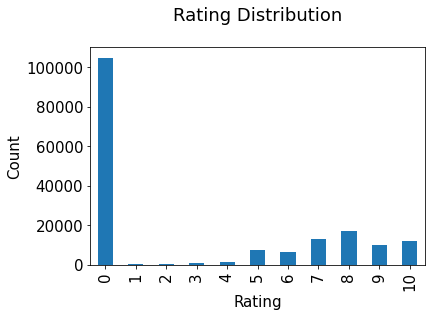

In [5]:
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

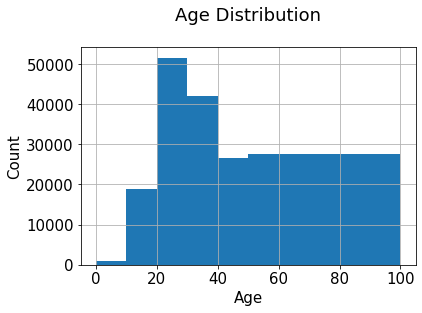

In [6]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

## To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded.

In [7]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

## Collaborative Filtering Using k-Nearest Neighbors (kNN)


kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors. For example, we first present ratings in a matrix with the matrix having one row for each item (book) and one column for each user,

In [8]:
# Merge 2 tables
combine_book_rating = pd.merge(ratings, books, on='ISBN')

# Remove unwanted columns
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']

#Removing raws having null values
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...


We then group by book titles and create a new column for total rating count.



In [9]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])

book_ratingCount = (combine_book_rating.
     groupby(by = ['bookTitle'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['bookTitle', 'totalRatingCount']]
    )
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,1
1,Beyond IBM: Leadership Marketing and Finance ...,1
2,Earth Prayers From around the World: 365 Pray...,1
3,Final Fantasy Anthology: Official Strategy Gu...,2
4,It Takes Two,1


Combining the rating data with the total rating count data.
This gives exactly what we need to find out which books are popular and filter out lesser-known books.

In [10]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,13
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,13
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,13
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,13
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,13


In [11]:
print(book_ratingCount['totalRatingCount'].describe())

count    32279.000000
mean         1.862790
std          2.298886
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         47.000000
Name: totalRatingCount, dtype: float64


In [12]:
# Top of the distribution
print(book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.90     3.0
0.91     4.0
0.92     4.0
0.93     4.0
0.94     5.0
0.95     5.0
0.96     6.0
0.97     7.0
0.98     9.0
0.99    12.0
Name: totalRatingCount, dtype: float64


In [14]:
# Define a threshold value
popularity_threshold = 30
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
152,277427,0142001740,0,The Secret Life of Bees,42
153,254,0142001740,9,The Secret Life of Bees,42
154,2766,0142001740,0,The Secret Life of Bees,42
155,4017,0142001740,0,The Secret Life of Bees,42
156,6543,0142001740,9,The Secret Life of Bees,42


In [15]:
rating_popular_book.shape


(738, 5)

In [16]:
# Filter to users in US and Canada only because the knn calculations are time and resource expensive
combined = rating_popular_book.merge(users, left_on = 'userID', right_on = 'userID', how = 'left')

us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating=us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,277427,0142001740,0,The Secret Life of Bees,42,"gilbert, arizona, usa"
1,254,0142001740,9,The Secret Life of Bees,42,"minneapolis, minnesota, usa"
2,2766,0142001740,0,The Secret Life of Bees,42,"frisco, texas, usa"
3,4017,0142001740,0,The Secret Life of Bees,42,"new orleans, louisiana, usa"
4,6543,0142001740,9,The Secret Life of Bees,42,"strafford, missouri, usa"


## Implementing kNN


In [17]:
from scipy.sparse import csr_matrix
# Drop duplicate raws
us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
# Creating the pivot table
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
# Converting the pivot table into a matrix
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [19]:
# Randomly select a book
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
print(query_index)

10


In [20]:
#Applying model
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)


In [21]:
us_canada_user_rating_pivot.index[query_index] # Name of the selected book

'The Firm'

In [22]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))


Recommendations for The Firm:

1: The Pelican Brief, with distance of 0.647125790013966:
2: A Painted House, with distance of 0.6656245255706555:
3: Message in a Bottle, with distance of 0.7669027984964126:
4: The Lovely Bones: A Novel, with distance of 0.7755194474402153:
5: The Chamber, with distance of 0.7823168498584281:
